The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [1]:
!pip install d2l==0.15.1
!pip install -U mxnet-cu101==1.7.0


     |████████████████████████████████| 61kB 4.8MB/s 
     |███████████████████████████████▌| 834.1MB 1.2MB/s eta 0:00:10tcmalloc: large alloc 1147494400 bytes == 0x64ed4000 @  0x7f36fc210615 0x591e47 0x4cc179 0x4cc2db 0x50a1cc 0x50beb4 0x507be4 0x509900 0x50a2fd 0x50beb4 0x507be4 0x509900 0x50a2fd 0x50cc96 0x58e683 0x50c127 0x58e683 0x50c127 0x58e683 0x50c127 0x58e683 0x50c127 0x5095c8 0x50a2fd 0x50beb4 0x507be4 0x509900 0x50a2fd 0x50beb4 0x5095c8 0x50a2fd
     |████████████████████████████████| 846.0MB 21kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


# Sentiment Analysis: Using Recurrent Neural Networks
:label:`sec_sentiment_rnn`


Similar to search synonyms and analogies, text classification is also a
downstream application of word embedding. In this section, we will apply
pre-trained word vectors (GloVe) and bidirectional recurrent neural networks with
multiple hidden layers :cite:`Maas.Daly.Pham.ea.2011`, as shown in :numref:`fig_nlp-map-sa-rnn`. We will use the model to
determine whether a text sequence of indefinite length contains positive or
negative emotion. 

![This section feeds pretrained GloVe to an RNN-based architecture for sentiment analysis.](https://github.com/d2l-ai/d2l-en-colab/blob/master/img/nlp-map-sa-rnn.svg?raw=1)
:label:`fig_nlp-map-sa-rnn`


In [2]:
pip install d2l

In [3]:
pip install mxnet

     |████████████████████████████████| 55.0MB 84kB/s 


In [4]:
from d2l import mxnet as d2l
from mxnet import gluon, init, np, npx
from mxnet.gluon import nn, rnn
npx.set_np()

batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

## Using a Recurrent Neural Network Model

In this model, each word first obtains a feature vector from the embedding
layer. Then, we further encode the feature sequence using a bidirectional
recurrent neural network to obtain sequence information. Finally, we transform
the encoded sequence information to output through the fully connected
layer. Specifically, we can concatenate hidden states of bidirectional
long-short term memory in the initial time step and final time step and pass it
to the output layer classification as encoded feature sequence information. In
the `BiRNN` class implemented below, the `Embedding` instance is the embedding
layer, the `LSTM` instance is the hidden layer for sequence encoding, and the
`Dense` instance is the output layer for generated classification results.


In [5]:
class BiRNN(nn.Block):
    def __init__(self, vocab_size, embed_size, num_hiddens,
                 num_layers, **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # Set `bidirectional` to True to get a bidirectional recurrent neural
        # network
        self.encoder = rnn.LSTM(num_hiddens, num_layers=num_layers,
                                bidirectional=True, input_size=embed_size)
        self.decoder = nn.Dense(2)

    def forward(self, inputs):
        # The shape of `inputs` is (batch size, no. of words). Because LSTM
        # needs to use sequence as the first dimension, the input is
        # transformed and the word feature is then extracted. The output shape
        # is (no. of words, batch size, word vector dimension).
        embeddings = self.embedding(inputs.T)
        # Since the input (embeddings) is the only argument passed into
        # rnn.LSTM, it only returns the hidden states of the last hidden layer
        # at different time step (outputs). The shape of `outputs` is
        # (no. of words, batch size, 2 * no. of hidden units).
        outputs = self.encoder(embeddings)
        # Concatenate the hidden states of the initial time step and final
        # time step to use as the input of the fully connected layer. Its
        # shape is (batch size, 4 * no. of hidden units)
        encoding = np.concatenate((outputs[0], outputs[-1]), axis=1)
        outs = self.decoder(encoding)
        return outs

Create a bidirectional recurrent neural network with two hidden layers.


In [6]:
embed_size, num_hiddens, num_layers, devices = 300, 100, 2, d2l.try_all_gpus()
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)
net.initialize(init.Xavier(), ctx=devices)

### Loading Pre-trained Word Vectors

Because the training dataset for sentiment classification is not very large, in order to deal with overfitting, we will directly use word vectors pre-trained on a larger corpus as the feature vectors of all words. Here, we load a 100-dimensional GloVe word vector for each word in the dictionary `vocab`.


In [7]:
glove_embedding = d2l.TokenEmbedding('glove.6b.300d')

Query the word vectors that in our vocabulary.


In [8]:
embeds = glove_embedding[vocab.idx_to_token]
embeds.shape

(49346, 300)

Then, we will use these word vectors as feature vectors for each word in the reviews. Note that the dimensions of the pre-trained word vectors need to be consistent with the embedding layer output size `embed_size` in the created model. In addition, we no longer update these word vectors during training.


In [9]:
net.embedding.weight.set_data(embeds)
net.embedding.collect_params().setattr('grad_req', 'null')

### Training and Evaluating the Model

Now, we can start training.


loss 0.204, train acc 0.919, test acc 0.878
8.8 examples/sec on [cpu(0)]


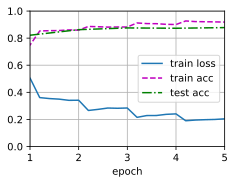

In [10]:
lr, num_epochs = 0.01, 5
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': lr})
loss = gluon.loss.SoftmaxCrossEntropyLoss()
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

Finally, define the prediction function.


In [11]:
#@save
def predict_sentiment(net, vocab, sentence):
    sentence = np.array(vocab[sentence.split()], ctx=d2l.try_gpu())
    label = np.argmax(net(sentence.reshape(1, -1)), axis=1)
    return 'positive' if label == 1 else 'negative'

Then, use the trained model to classify the sentiments of two simple sentences.


In [12]:
predict_sentiment(net, vocab, 'this movie is so great')

'positive'

In [20]:
predict_sentiment(net, vocab, 'this movie is bad, I did not enjoyed it a lot')

'positive'

## Summary

* Text classification transforms a sequence of text of indefinite length into a category of text. This is a downstream application of word embedding.
* We can apply pre-trained word vectors and recurrent neural networks to classify the emotions in a text.


## Exercises

1. Increase the number of epochs. What accuracy rate can you achieve on the training and testing datasets? What about trying to re-tune other hyperparameters?
1. Will using larger pre-trained word vectors, such as 300-dimensional GloVe word vectors, improve classification accuracy?
1. Can we improve the classification accuracy by using the spaCy word tokenization tool? You need to install spaCy: `pip install spacy` and install the English package: `python -m spacy download en`. In the code, first import spacy: `import spacy`. Then, load the spacy English package: `spacy_en = spacy.load('en')`. Finally, define the function `def tokenizer(text): return [tok.text for tok in spacy_en.tokenizer(text)]` and replace the original `tokenizer` function. It should be noted that GloVe's word vector uses "-" to connect each word when storing noun phrases. For example, the phrase "new york" is represented as "new-york" in GloVe. After using spaCy tokenization, "new york" may be stored as "new york".


[Discussions](https://discuss.d2l.ai/t/392)
